# Mean Variance Portfolio Optimisation

### Introduction 

### Dataset

In [1]:
import polars as pl

DATASET_DIR = "../datasets"

# Add a 'symbol' column to the dataset to identify the symbol after merging the datasets
btcusdt = pl.read_csv(f'{DATASET_DIR}/bybit_BTCUSDT_4h.csv').with_columns(symbol=pl.lit("BTCUSDT"))
ethusdt = pl.read_csv(f'{DATASET_DIR}/bybit_ETHUSDT_4h.csv').with_columns(symbol=pl.lit("ETHUSDT"))
adausdt = pl.read_csv(f'{DATASET_DIR}/bybit_ADAUSDT_4h.csv').with_columns(symbol=pl.lit("ADAUSDT"))
maticusdt = pl.read_csv(f'{DATASET_DIR}/bybit_MATICUSDT_4h.csv').with_columns(symbol=pl.lit("MATICUSDT"))

dfs = [btcusdt, ethusdt, adausdt, maticusdt]

In [2]:
for i in range(len(dfs) - 1):
    # Make sure the datasets has the same number of rows
    assert(dfs[i]['timestamp'].count() == dfs[i + 1]['timestamp'].count())

    # Make sure the datasets has the same start and end time
    assert(dfs[i]['timestamp'][0] == dfs[i + 1]['timestamp'][0])
    assert(dfs[i]['timestamp'][-1] == dfs[i + 1]['timestamp'][-1])

In [3]:
from datetime import datetime, timezone

start = datetime.fromtimestamp(btcusdt['timestamp'][0] / 1000, tz=timezone.utc)
end = datetime.fromtimestamp(btcusdt['timestamp'][-1] / 1000, tz=timezone.utc)
duration = (btcusdt['timestamp'][1] - btcusdt['timestamp'][0]) // 1000 // 60

print(f"The datasets are from {start} to {end} with interval of {duration} minute.")

df = pl.concat(dfs)
df.describe()

The datasets are from 2022-01-01 00:00:00+00:00 to 2024-02-04 20:00:00+00:00 with interval of 240 minute.


statistic,timestamp,open,high,low,close,volume,symbol
str,f64,f64,f64,f64,f64,f64,str
"""count""",18360.0,18360.0,18360.0,18360.0,18360.0,18360.0,"""18360"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",1.6740e12,7772.060085,7833.128377,7708.701182,7771.798649,752914.260244,null
"""std""",1.9081e10,13122.879805,13225.559288,13016.249457,13122.386146,1.8064e6,null
"""min""",1.6410e12,0.238,0.2422,0.2186,0.238,40.265839,"""ADAUSDT"""
"""25%""",1.6575e12,0.6363,0.6492,0.6254,0.6363,2290.26365,null
"""50%""",1.6740e12,914.47,973.94,880.84,914.47,81171.8,null
"""75%""",1.6906e12,3848.87,3892.53,3816.27,3848.87,820492.57,null
"""max""",1.7071e12,47941.2,48975.0,47350.0,47941.2,4.5479e7,"""MATICUSDT"""


### Calculation

Calculating `returns` and `expected_returns` for each symbol.

In [4]:
# Calculate the returns of each subsequent closing price, note that the 
# first one will be null since it has no previous price to compare against,
# so we fill the null value with mean returns
df = df.with_columns(returns=df['close'].pct_change())
df = df.with_columns(returns=df['returns'].fill_null(df['returns'].mean())) 

# Expected returns is the mean of all returns from each symbol.
expected_returns = df.group_by('symbol').agg(pl.col('returns').mean())

expected_returns

symbol,returns
str,f64
"""ADAUSDT""",-0.000277
"""MATICUSDT""",0.000844
"""ETHUSDT""",-0.000202
"""BTCUSDT""",0.000043


### Optimising for portfolio weights

Before doing any optimisation, we first need to compute the covariance matrix for returns of all symbols, the covariance matrix will be used later for optmisation.

In [5]:
import numpy as np

num_symbols = len(df["symbol"].unique())

covariance_matrix = (
    df.to_pandas()
    .pivot_table(index="timestamp", columns="symbol", values="returns", aggfunc=np.mean)
    .cov()
)

covariance_matrix

/var/folders/g6/g_l62tm55tq0dym0qgl0ylwc0000gn/T/ipykernel_55021/1100454105.py:7: FutureWarning: The provided callable <function mean at 0x10b1f6660> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .pivot_table(index="timestamp", columns="symbol", values="returns", aggfunc=np.mean)


symbol,ADAUSDT,BTCUSDT,ETHUSDT,MATICUSDT
symbol,,,,
ADAUSDT,0.000523,0.000143,0.000386,-0.000642
BTCUSDT,0.000143,0.000125,0.000139,0.000166
ETHUSDT,0.000386,0.000139,0.000386,-0.000601
MATICUSDT,-0.000642,0.000166,-0.000601,0.004157


### Mean Variance Optimisation

As the name suggests, we define a problem whereby the objective is to minimise the portfolio risk (negative returns) to maximise returns.

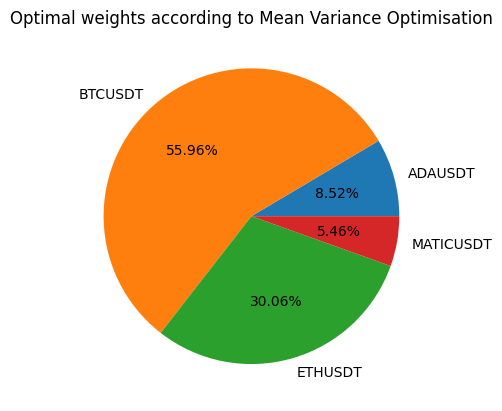

In [94]:
import cvxpy as cp
import matplotlib.pyplot as plt

weights = cp.Variable(num_symbols)

constraints = [
    cp.sum(weights) == 1,
    weights >= 0
]

# NOTE: the @ symbol is for computing the dot product of two matrices
portfolio_risk = cp.quad_form(weights @ covariance_matrix.values, np.eye(num_symbols))

objective = cp.Minimize(portfolio_risk)
problem = cp.Problem(objective, constraints)

problem.solve()

plt.title("Optimal weights according to Mean Variance Optimisation")
plt.pie(weights.value, labels=covariance_matrix.columns.to_list(), autopct='%1.2f%%')
plt.show()